In [1]:
from typing import cast
from classiq import *
from classiq.execution import ExecutionPreferences, IBMBackendPreferences, IBMBackendProvider
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import re
import config

In [2]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

def pauli_str(dim):
    Asq = [[] for _ in range(2**dim)]
    for i in range(len(Asq)):
        if i > 1:
            Asq[i].extend([0]*(i-1))
        if i > 0:
            Asq[i].append(2 if i == 2**(dim-1) else np.sqrt(2))
        Asq[i].append(0)
        if i < 2**dim-1:
            Asq[i].append(2 if i == 2**(dim-1)-1 else np.sqrt(2))
        if i < 2**dim-2:
            Asq[i].extend([0]*(2**dim-2-i))
    A = np.subtract(3*np.identity(2**dim), np.array(Asq))
    output = str(qml.pauli_decompose(A))
    pauli = ["".join([j for j in i if j.isalpha()]) for i in re.findall(r'\[.*?\]', output)]
    consts = [float(i[1:-1]) for i in re.findall(r'\(.*?\)', output)]
    return [(pauli[i], consts[i]) for i in range(len(pauli))]

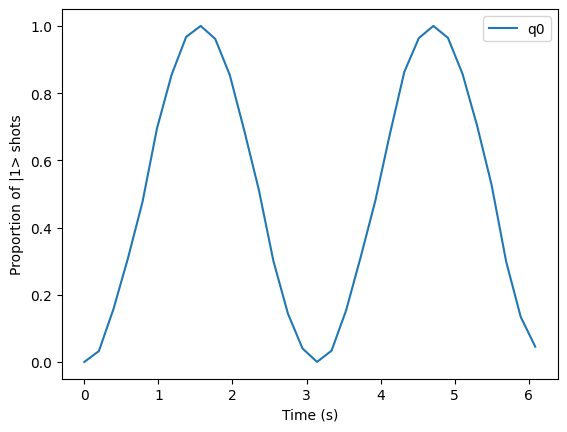

In [33]:
def one_oscillator(t):
    pauli_list=[
        ("Y", 1),
    ]
    @QFunc
    def main() -> None:
        state = QArray("state")
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=400,
            qbv=state,
        )
    model = create_model(main)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    results = job.result()
    return results[0].value.counts_of_qubits(0)

times = np.arange(0, 2*np.pi, np.pi/16)
output = []
for t in times:
    try:
        output.append(one_oscillator(t)['1']/2048)
    except KeyError:
        output.append(0)
plt.plot(times, output, label='q0')

plt.xlabel("Time (s)")
plt.ylabel("Proportion of |1> shots")
plt.legend()

plt.show()

In [35]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim)
    def add_point(t):
        @QFunc
        def main() -> None:
            state = QArray("state")
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=t,
                max_depth=(dim+2)*1000,
                qbv=state,
            )
        model = create_model(main)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value.parsed_counts
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point[index].shots/2048)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

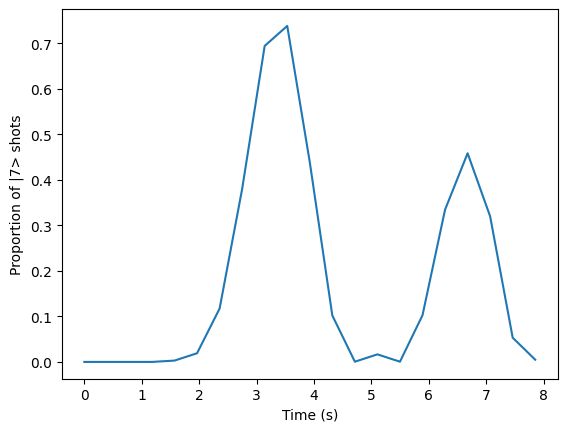

In [12]:
n_oscillators(3, 8, np.pi/8)

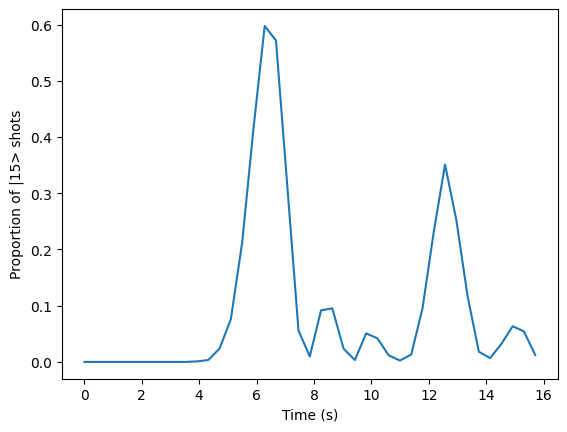

In [13]:
n_oscillators(4, 16, np.pi/8)

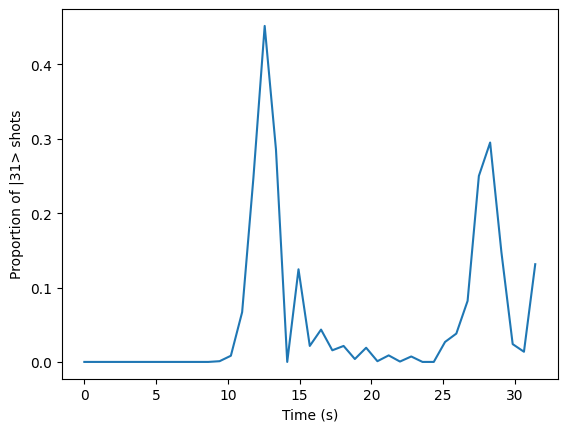

In [28]:
n_oscillators(5, 32, np.pi/4)

In [2]:
def sim_point(dim, t):
    pauli_list = pauli_str(dim)
    @QFunc
    def main() -> None:
        state = QArray("state")
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=(dim+2)*1000,
            qbv=state,
        )
    model = create_model(main)
    quantum_program = synthesize(model)
    job = execute(quantum_program)
    results = job.result()
    return results[0].value.parsed_counts

def run_point(dim, t):
    pauli_list = pauli_str(dim)
    @QFunc
    def main() -> None:
        state = QArray("state")
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=(dim+2)*1000,
            qbv=state,
        )
    preferences = IBMBackendPreferences(
        backend_name='ibm_brisbane',
        access_token=config.ibm_key,
    )
    execution_preferences = ExecutionPreferences(backend_preferences=preferences)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    execute(quantum_program)

In [5]:
run_point(3, 6.75)

The current version of 'classiq' has been deprecated, and will not be supported as of 2024-04-11. Please run "pip install -U classiq" to upgrade the classiq SDK to the latest version.


In [ ]:
run_point(4, 12.25)

In [ ]:
run_point(5, 28)